In [90]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import save_img, to_categorical
import os
import shutil 
import pathlib

## 1. Testing the color change of an arbitrary image

In [3]:
dir_path_ex = "../Data/retinal-lesions-v20191227/lesion_segs_896x896/9_left"
cvs_example = "cotton_wool_spots.png"
example_img_path = os.path.join(dir_path_ex, cvs_example)

In [22]:
def process_annotation(file_path):
  file_name = tf.io.read_file(file_path)
  img = tf.io.decode_png(file_name)
  #img = img - 1
  #img = tf.image.resize(img, [224, 224])
  return img




In [88]:
ex_img = load_img(example_img_path)
a = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)

In [73]:
ex_arr = img_to_array(ex_img)
ex_arr.shape

(896, 896, 1)

`c` is an array of arrays, it contains 3 arrays for each axes where nonzero values are present, the first array corresponds to the indices along the width, the second array corresponds to the incides along the height, and the third array corresponds to the indices along the pixel values. Observing the third array of `c` shows an interesting pattern.

![image](./Screen%20Shot%202022-10-30%20at%204.25.43%20PM.png)

These correspond to the way a white pixel is, 255 along all three indices.

Simply looking at the first and second array does not present any interesting information since they are arbitrary numbers.

To modify the pixel values withing an image, the image array must be indexed using the first and second array of `c`. These corresponding pixel arrays will be the white pixels, and will be a matrix of size `nx3` where `n` is the number of of pixels which are white. In this test case, the each white pixel `[255, 255, 255]` is being replaced with a red pixed `[255, 0, 0]`. This red pixel needs to be broadcasted to the same number of white pixels present, and then its just a matter of simple assignment.

In [74]:
#Finding all the pixels which are white, these will be nonzero values
c = np.nonzero(ex_arr)
#
#repeat factor
#r = len(ex_arr[c])
#red = np.array([[0, 255 ,0]])
#red = np.repeat(red, r, axis=0)
ex_arr[c[0], c[1], :] = 127


In [75]:
c

(array([167, 167, 167, ..., 424, 424, 424]),
 array([488, 489, 490, ..., 555, 556, 557]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [76]:
ex_arr[c[0], c[1], :].shape

(8740, 1)

In [77]:
np.unique(ex_arr)

array([  0., 127.], dtype=float32)

In [78]:
n_img = array_to_img(ex_arr)

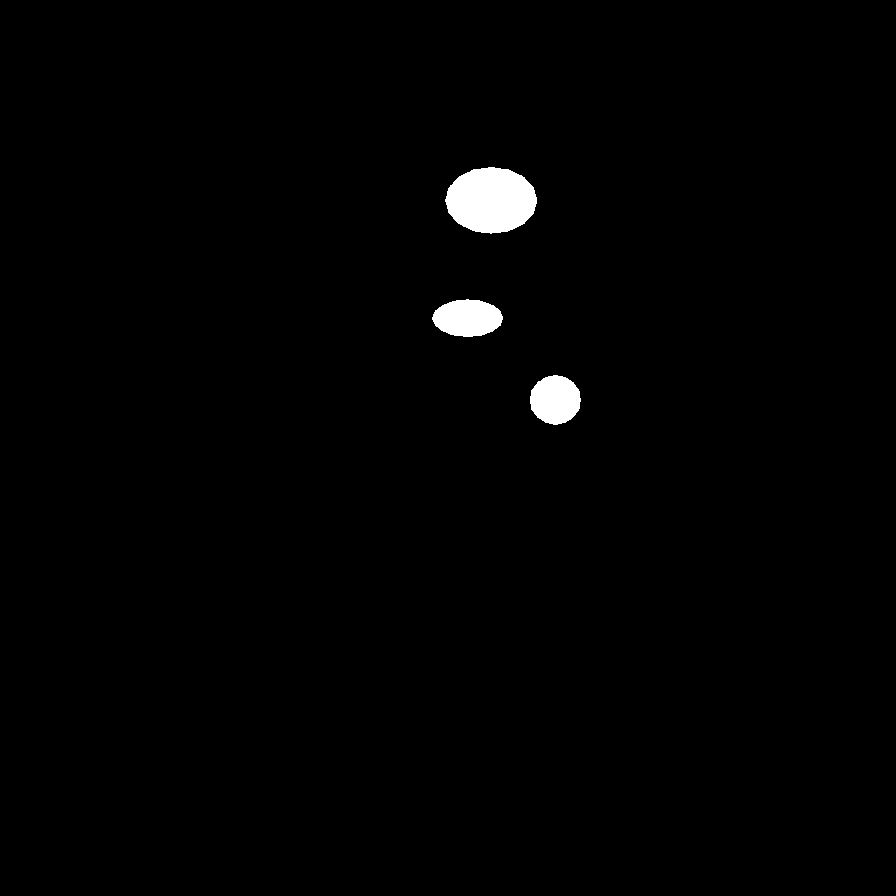

In [80]:
n_img

In [71]:
c = np.nonzero(ex_arr[:,:])

In [72]:
c

(array([167, 167, 167, ..., 424, 424, 424]),
 array([488, 489, 490, ..., 555, 556, 557]),
 array([0, 0, 0, ..., 0, 0, 0]))

### 1.1 Testing with a tiny image

In [167]:
arr = np.arange(27).reshape(3, 3, 3)
arr = np.array([[[ 0, 0,  0],
        [ 0, 0,  0],
        [ 0,  0,  0]],

       [[ 0, 0, 0],
        [255,0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])


In [168]:
arr

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [255,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]])

In [169]:
arr.T

array([[[  0,   0,   0],
        [  0, 255,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]])

In [170]:
a_img = array_to_img(arr)

In [171]:
a_img

## 2. Creating a program that can identify the type of lesion, and modify color accordingly.

In [301]:
ihe = "retinal_hemorrhage"
se = "cotton_wool_spots"
he = "hard_exudate"
ma = "microaneurysm"

#lesion_indices = {ihe:0, se:1, he:2, ma:3}
#lesion_names = {0:ihe, 1:se, 2:he, 3:ma}

In [287]:
def identify(fn):

    ihe = "retinal_hemorrhage"
    se = "cotton_wool_spots"
    he = "hard_exudate"
    ma = "microaneurysm"

    lesion_indices = {ihe:0, se:1, he:2, ma:3}
    lesion_names = {0:ihe, 1:se, 2:he, 3:ma}

    try:
        i = lesion_indices[fn[:-4]]
    except KeyError:
        i = -1
    
    return i


In [288]:
def ret_color(i):


    ma = np.array([[245, 128, 128]])
    se = np.array([[128, 242, 128]])
    he = np.array([[245, 234, 133]])
    ihe = np.array([[133, 213, 245]])

    lesion_colors = {0:ihe, 1:se, 2:he, 3:ma}

    try:
        c = lesion_colors[i]
    except KeyError:
        c = -1
    
    return c

In [432]:
def color_for_file(fn):

    i = identify(fn)

    c = ret_color(i)

    return c

### 2.1 Testing color retreival with arbitrary images

In [303]:
test_dir = "../Data/retinal-lesions-v20191227/lesion_segs_896x896/1471_right"
cvs_path = se + ".png"
he_path = he + ".png"
ma_path = ma + ".png"
ihe_path = ihe + ".png"

In [305]:
cvs_path

'cotton_wool_spots.png'

### 2.2 Color change function for an image

In [306]:
cvs_path_f = os.path.join(test_dir, cvs_path)
he_path_f = os.path.join(test_dir, he_path)
ma_path_f = os.path.join(test_dir, ma_path)
ihe_path_f = os.path.join(test_dir, ihe_path)

In [304]:
cvs_color = color_for_file(cvs_path)
he_color = color_for_file(he_path)
ma_color = color_for_file(ma_path)
ihe_color = color_for_file(ihe_path)


In [307]:
def color_change(fp, color):

    img = load_img(fp)
    arr = img_to_array(img)
    #Finding all the pixels which are white, these will be nonzero values
    c = np.nonzero(arr[:,:])
    #
    #repeat factor
    r = len(arr[c])
    #Creating color pixels for each pixel that was white
    color = np.repeat(color, r, axis=0)
    arr[c[0], c[1], :] = color
    n_img = array_to_img(arr)

    return n_img

    

    

In [337]:
def find_and_change(fn, fp):

    c = color_for_file(fn)
    if type(c) != int: 
        ni = color_change(fp, c)
    else:
        return -1
    return ni

In [338]:
cvs_path_f

'../Data/retinal-lesions-v20191227/lesion_segs_896x896/1471_right/cotton_wool_spots.png'

In [339]:
ni = color_change(cvs_path_f, cvs_color)
n2 = color_change(he_path_f, he_color)
n3 = color_change(ihe_path_f, ihe_color)
n4 = color_change(ma_path_f, ma_color)

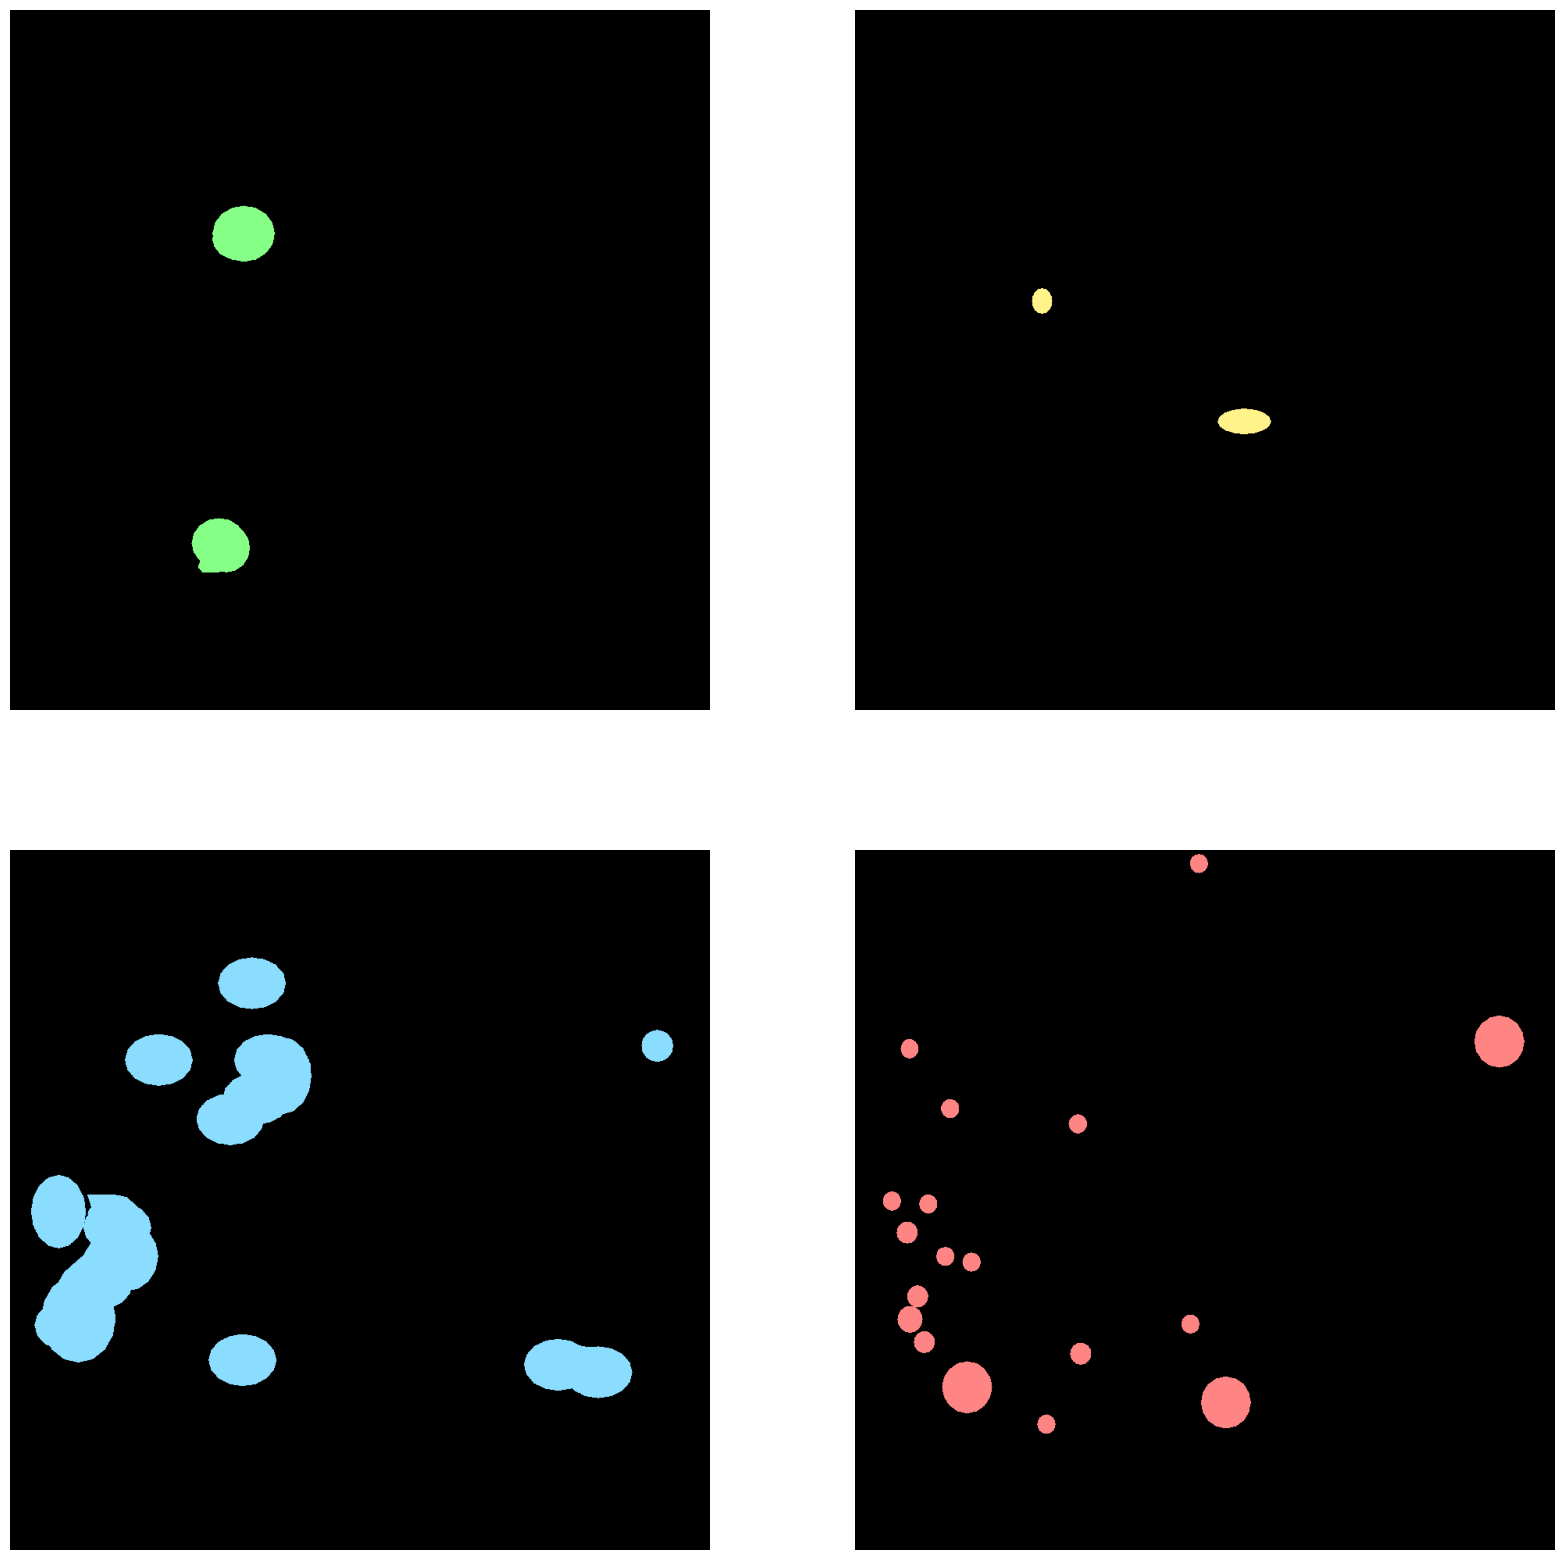

In [340]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize = (20, 20))

ax[0,0].imshow(ni)
ax[0,1].imshow(n2)
ax[1,0].imshow(n3)
ax[1,1].imshow(n4)

ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")
plt.show()

## 3 Modifying all images

In [352]:
data_path = "../Data/retinal-lesions-v20191227/lesion_segs_896x896/"
file_num = 0
for dp, dn, fn in os.walk(data_path):
    for f in fn:

        fp = os.path.join(dp, f)
        ni = find_and_change(f, fp)

        if type(ni) is not int:
            new_fp = fp[:-4] + "N.png"

            save_img(new_fp, ni, data_format="channels_last")
    
        



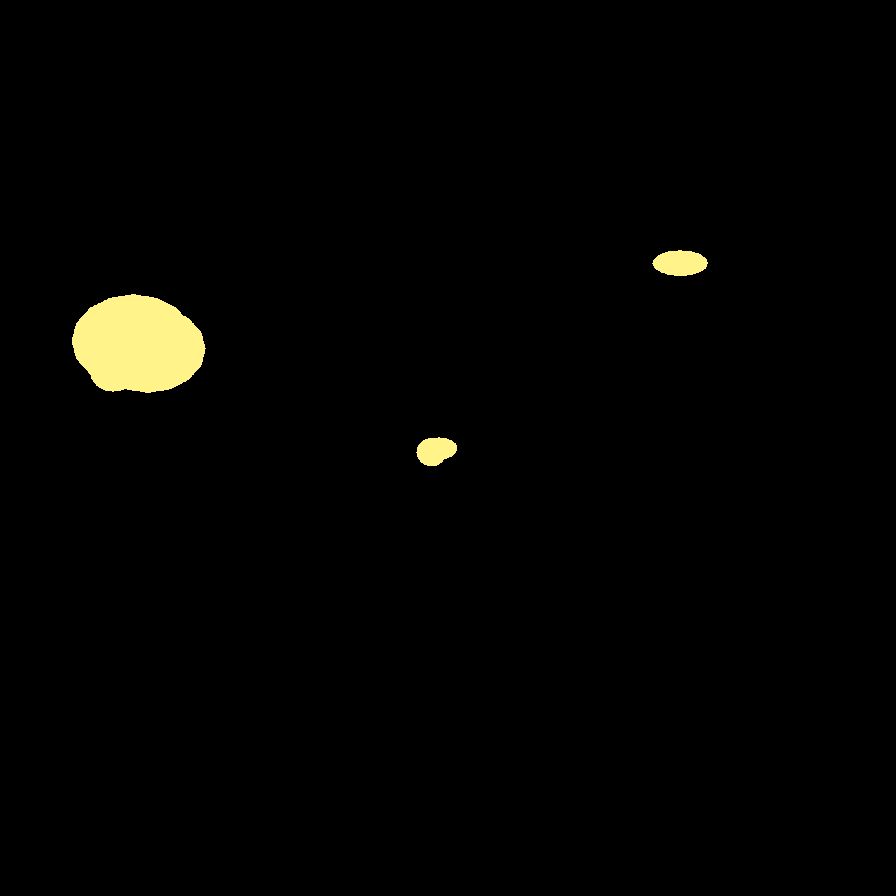

In [344]:
ni

In [347]:
save_img("t.png", ni, data_format="channels_last")

In [349]:
if type(1) == int: print("numberrr")

numberrr


## 4 Combining images

### 4.1 Combining non-overlapping images

In [353]:
test_data_path = "../Data/retinal-lesions-v20191227/lesion_segs_896x896/78_left"

In [364]:
files = []
for f in os.listdir(test_data_path):
    if "N" in f:
        files.append(os.path.join(test_data_path,f))

In [365]:
files

['../Data/retinal-lesions-v20191227/lesion_segs_896x896/78_left/microaneurysmN.png',
 '../Data/retinal-lesions-v20191227/lesion_segs_896x896/78_left/cotton_wool_spotsN.png']

In [367]:
mask = np.zeros((896, 896, 3))
def simple_combine(files, img1):
    
    if len(files) == 0:
        return img1
    else:
        
        fp = files.pop(0)
        img2 = load_img(fp)
        img2 = img_to_array(img2)
        img1 = img1 + img2
        return simple_combine(files, img1)
    

In [366]:
files

['../Data/retinal-lesions-v20191227/lesion_segs_896x896/78_left/microaneurysmN.png',
 '../Data/retinal-lesions-v20191227/lesion_segs_896x896/78_left/cotton_wool_spotsN.png']

In [368]:
ni = simple_combine(files, mask)

In [369]:
ni.shape

(896, 896, 3)

In [370]:
ni = array_to_img(ni)

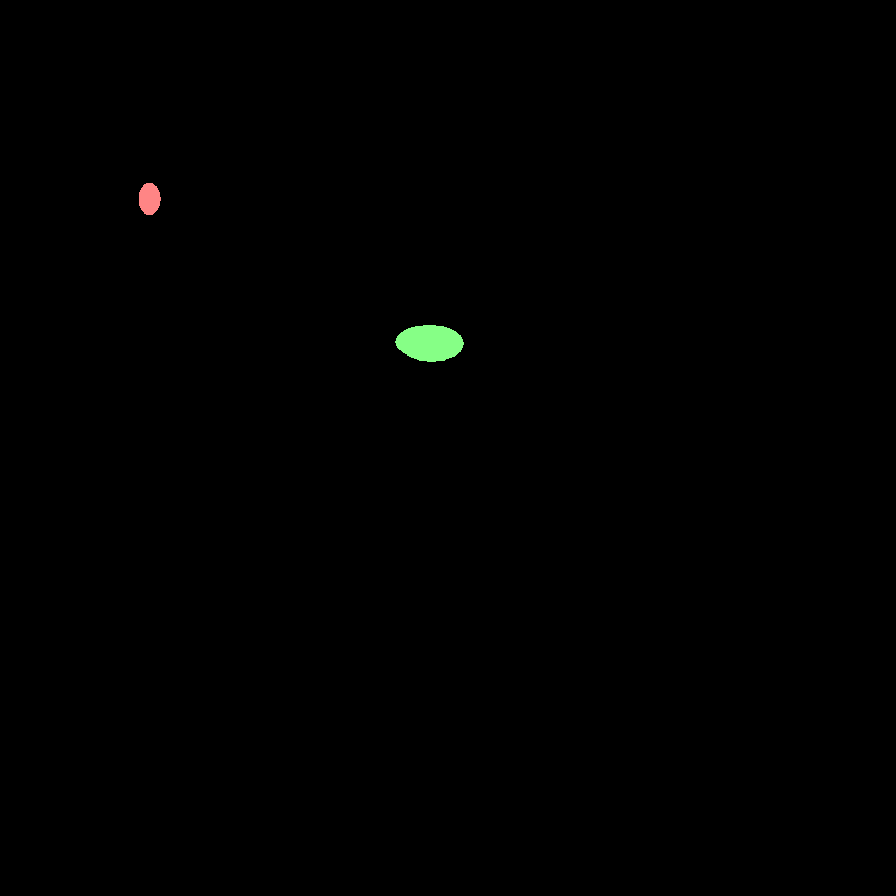

In [371]:
ni

The simple approach works for lesions that don't overlap!

### 4.2 Creating an algorithm to combine overlapping lesions

In [535]:
test_dir_path = "../Data/retinal-lesions-v20191227/lesion_segs_896x896/1077_right"

#### 4.2.1 Creating a sorting algorithm to sort the files by order

In [554]:
def extract_lesion_files(dir_path):

    '''This function takes a directory where there might be multiple lesion files, 
    and returns a list of (the full file path, the name of the file, and the color for the lesion) those
    lesion files which have been modified.
    '''
    ihe = "retinal_hemorrhageN"
    se = "cotton_wool_spotsN"
    he = "hard_exudateN"
    ma = "microaneurysmN"

    lesion_indices = {ihe:2, se:0, he:1, ma:3}
    lesion_names = {0:ihe, 1:se, 2:he, 3:ma}
    files = []
    # return [(os.path.join(dir_path, f), f) for f in os.listdir(dir_path) if "N" in f]
    for f in os.listdir(dir_path):
        try:
            
            lesion_indices[f[:-4]]
            c = color_for_file(f.replace("N", ""))
            files.append((os.path.join(dir_path,f), f, c))
        except:
            continue
    
    return files 



In [555]:
files = extract_lesion_files(test_dir_path)

In [556]:
print(files)

[('../Data/retinal-lesions-v20191227/lesion_segs_896x896/1077_right/microaneurysmN.png', 'microaneurysmN.png', array([[245, 128, 128]]))]


In [539]:
def sort_lesions(files):

    '''This function takes a list of filepaths, filenames, and colors and returns the list
    sorted by the order of importance of the lesion
    '''

    ihe = "retinal_hemorrhageN"
    se = "cotton_wool_spotsN"
    he = "hard_exudateN"
    ma = "microaneurysmN"

    lesion_indices = {ihe:2, se:0, he:1, ma:3}
    lesion_names = {0:ihe, 1:se, 2:he, 3:ma}

    sorted_paths = sorted(files, key=lambda x: lesion_indices[x[1][:-4]])

    return sorted_paths

In [540]:
s_files = sort_lesions(files)

In [541]:
s_files

[('../Data/retinal-lesions-v20191227/lesion_segs_896x896/1077_right/microaneurysmN.png',
  'microaneurysmN.png',
  array([[245, 128, 128]]))]

#### 4.2.2 Proper image combining alogirithm

In [542]:
mask = np.zeros((896, 896, 3))

def check_overflow(a):
    return np.nonzero(a > 255)

def color_change(fp, color):

    img = load_img(fp)
    arr = img_to_array(img)
    #Finding all the pixels which are white, these will be nonzero values
    c = np.nonzero(arr[:,:])
    #
    #repeat factor
    r = len(arr[c])
    #Creating color pixels for each pixel that was white
    color = np.repeat(color, r, axis=0)
    arr[c[0], c[1], :] = color
    n_img = array_to_img(arr)

    return n_img

def replace_colors(c, arr, color):

    r = len(arr[c])
    #Creating color pixels for each pixel that was white
    color = np.repeat(color, r, axis=0)
    arr[c[0], c[1], :] = color

    return arr

def full_combine(files, img1):

    '''Given a list of files, this function combines the lesions into one segmentation map'''

    if len(files) == 0:
        return img1
    else:
        f = files.pop(0)
        fp = f[0]
        fc = f[2]

        img2 = load_img(fp)
        img2 = img_to_array(img2)
        img1 = img1 + img2
        response_c = check_overflow(img1)
        img1 = replace_colors(response_c, img1, fc)
        
        return full_combine(files, img1)
    

In [543]:
ni = full_combine(s_files, mask)

In [544]:
save_img("t.png", ni)

In [545]:
ni = array_to_img(ni)

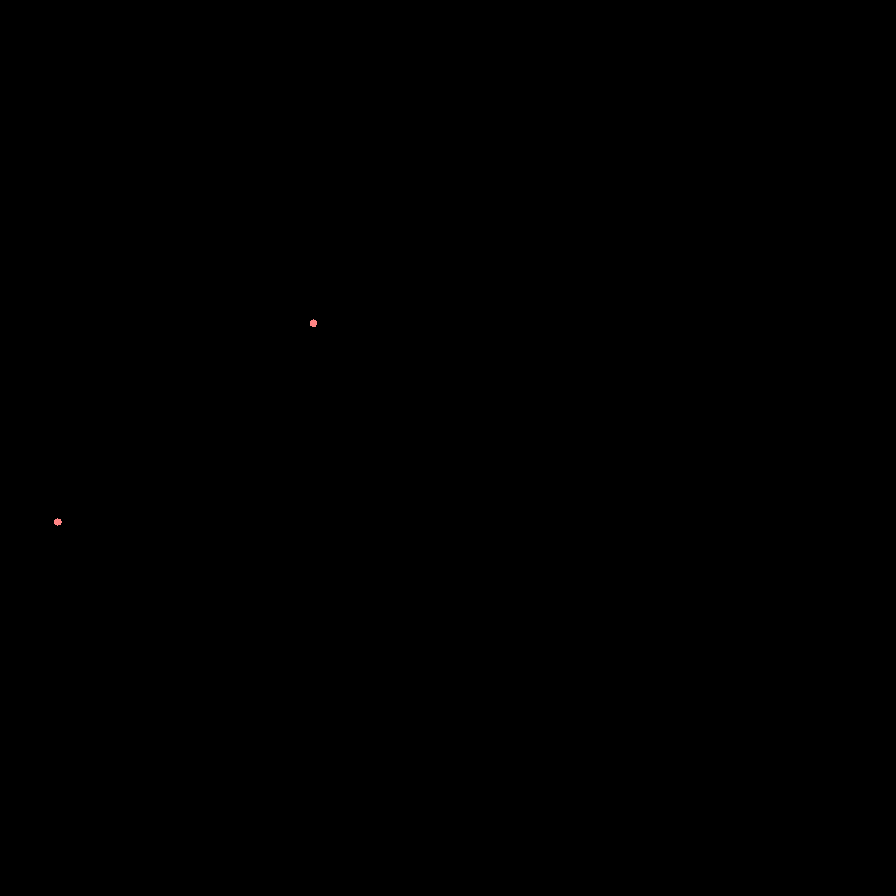

In [546]:
ni

## 5 Processing all segmentation maps (per eye) into a single image

This procedure will require the following functions: `extract_lesion_files`, `sort_lesions`, and `full_combine`.

In [559]:
i = 0
main_dir = "../Data/retinal-lesions-v20191227/lesion_segs_896x896"
mask = np.zeros((896, 896, 3))
for dn, dp, fn in os.walk(main_dir):
    if i == 0: 
        i += 1
        continue
    file_name = dn[54:] + ".png"
    file_path = os.path.join(dn, file_name)
    files = extract_lesion_files(dn)
    #print(files)
    sorted_files = sort_lesions(files)
    #print(sorted_files)
    img_arr = full_combine(sorted_files, mask)
    #img = array_to_img(img_arr)
    save_img(file_path, img_arr, data_format="channels_last")
    i += 1
    print(f"Processing image {i} next..")
    #break


Processing image 2 next..
Processing image 3 next..
Processing image 4 next..
Processing image 5 next..
Processing image 6 next..
Processing image 7 next..
Processing image 8 next..
Processing image 9 next..
Processing image 10 next..
Processing image 11 next..
Processing image 12 next..
Processing image 13 next..
Processing image 14 next..
Processing image 15 next..
Processing image 16 next..
Processing image 17 next..
Processing image 18 next..
Processing image 19 next..
Processing image 20 next..
Processing image 21 next..
Processing image 22 next..
Processing image 23 next..
Processing image 24 next..
Processing image 25 next..
Processing image 26 next..
Processing image 27 next..
Processing image 28 next..
Processing image 29 next..
Processing image 30 next..
Processing image 31 next..
Processing image 32 next..
Processing image 33 next..
Processing image 34 next..
Processing image 35 next..
Processing image 36 next..
Processing image 37 next..
Processing image 38 next..
Processin

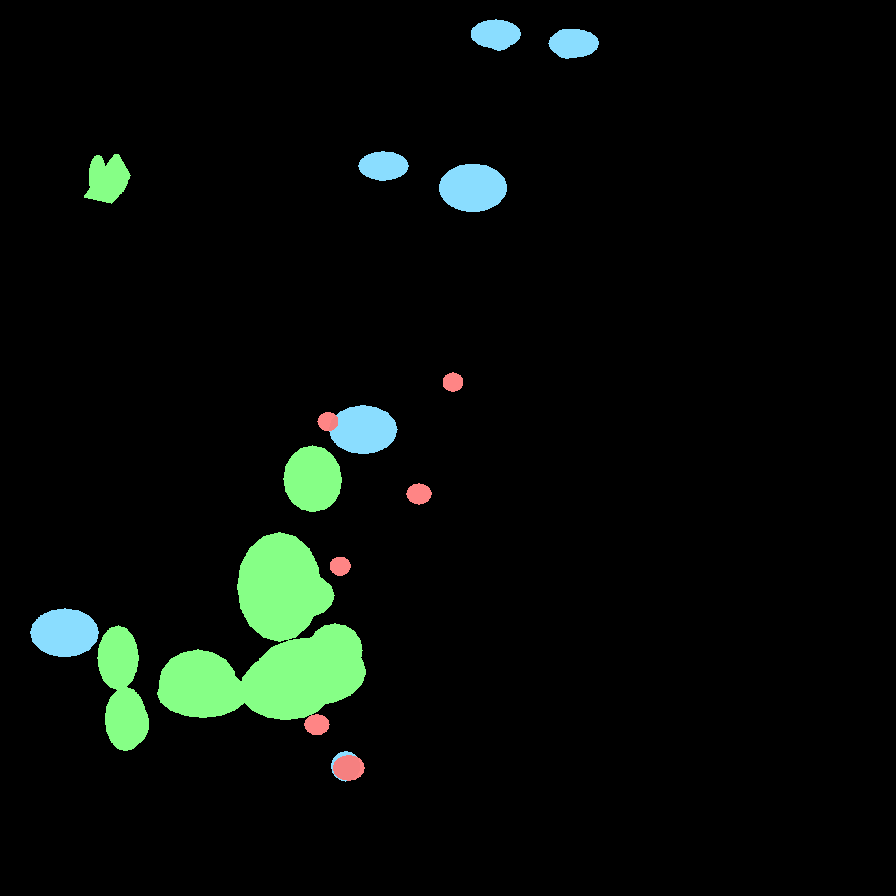

In [558]:
img

In [91]:
len("../Data/retinal-lesions-v20191227/lesion_segs_896x896/")

54

In [92]:
print("../Data/retinal-lesions-v20191227/lesion_segs_896x896/38296_left"[54:])

38296_left


NameError: name 'i' is not defined

## 6 Example Image

In [94]:
img_path = "../Data/retinal-lesions-v20191227/images_896x896/9_left.jpg"
img = load_img(img_path)

In [100]:
annotation_path = "../Data/retinal-lesions-v20191227/lesion_segs_896x896/9_left/retinal_hemorrhage.png"
annotation = load_img(annotation_path)

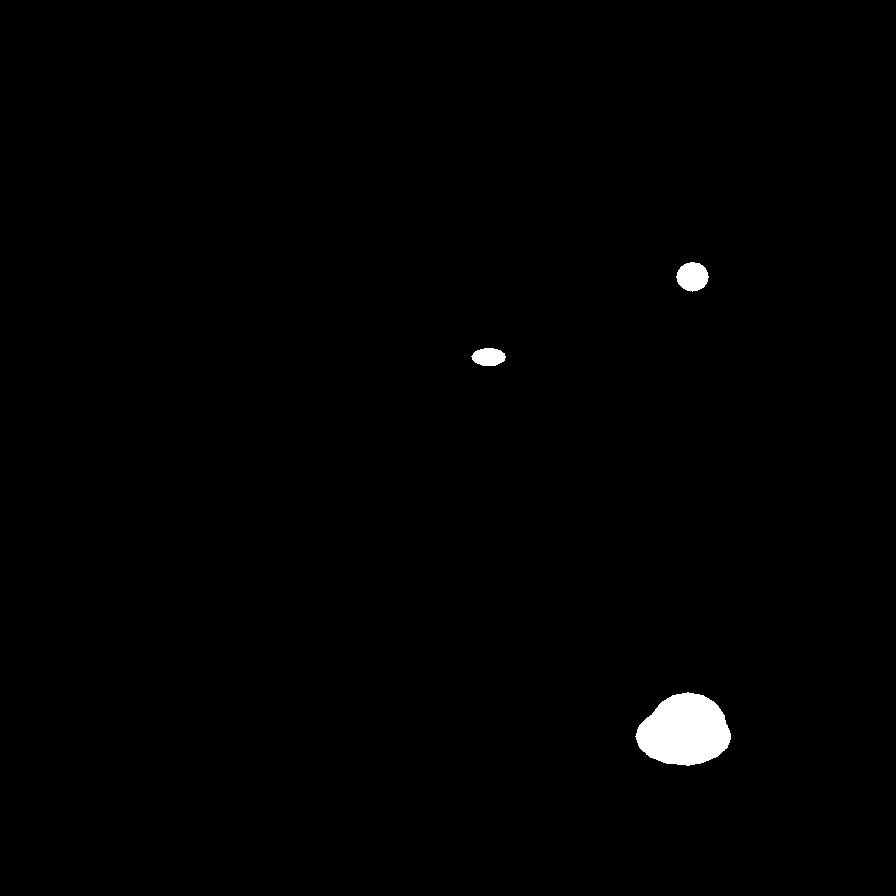

In [101]:
annotation